## Importing Packages

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Packages Used ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#------------------------To solve the ODE----------------------------
using DifferentialEquations
#using LSODA

#------------------------For Calling Python---------------------------
using PyCall
np = pyimport("numpy")
using SciPy
using Plots

#------------------------Writing Data to CSV file---------------------
using CSV
using Tables

## Input Disctionary 

In [6]:
input_dict = Dict(
    # System Parameters 
    :Mbh=>1e5, # Black hole [Msol] 
    :Mc=>1e2, # Compact object [Msol]
    :D=>1e5, # luminosity distance
    :e0=>0.0,
    :phi0=>0.0,
    :norbits=>1e3, # number of orbits
    :t_orbital=>1e2, # time points per orbital 
    :t_start=>0.0,
    :coulombLog=>3.0,
    # System model flags
    :gwEmission=>true,
    :dynamicalFriction=>true,
    :postNewtonian=>true,
    :dmModel=>"Relativistic", # or "Newtonian" 
    :dfModel=>"Relativistic", # or "Newtonian"
    # Eda scale parameters
    :a=>23.1, # [pc]
    :rho0=> 3.8e-22 .* 7.071e8, # [g/cm^3 to 1/pc^2]  
    # NFW parameters
    :alpha=>0.331,
    :beta=>-1.66,
    :gamma=>0.32,
    :delta=>-0.000282,
    # NFW relativistic parameters
    :eta=>1,
    :A=>6.42,
    :w=>1.82,
    :q=>1.91,
    # spike param
    :alpha_ini=>0.0,
)
# t_end, t_start=0., gwEmission=true, dynamicalFriction=true, PostNewtonian=true, coulombLog=3., nSteps=1000

Dict{Symbol, Any} with 25 entries:
  :alpha             => 0.331
  :gwEmission        => true
  :rho0              => 2.68698e-13
  :gamma             => 0.32
  :D                 => 100000.0
  :t_start           => 0.0
  :coulombLog        => 3.0
  :delta             => -0.000282
  :dmModel           => "Relativistic"
  :w                 => 1.82
  :postNewtonian     => true
  :eta               => 1
  :e0                => 0.0
  :A                 => 6.42
  :dynamicalFriction => true
  :phi0              => 0.0
  :norbits           => 1000.0
  :dfModel           => "Relativistic"
  :q                 => 1.91
  :Mbh               => 100000.0
  :a                 => 23.1
  :beta              => -1.66
  :alpha_ini         => 0.0
  :Mc                => 100.0
  :t_orbital         => 100.0

## Density Functions

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Defining the System ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#---------------------------System Parameteres------------------------

function r_isco(; kwargs...)    
    """
    Radius of the Innermost Stable Circular Orbit (ISCO) of a Schwarzschild black hole with mass m
    """
    # Conversion 
    solar_mass_to_pc = 4.8e-14
    
    Mbh = kwargs[:Mbh]
    Mbh *= solar_mass_to_pc
    return 6.0*float(Mbh)
end

function a_0(; kwargs...)
    """
    100 * r_isco
    """
    return 100.0*r_isco(; kwargs...)
    
end

#---------------------------Initial Arrays-----------------------------------

function mass_A(; kwargs...)
    solar_mass_to_pc = 4.8e-14
    Mbh = kwargs[:Mbh] * solar_mass_to_pc
    Mc = kwargs[:Mc] * solar_mass_to_pc
    
    m_total = (Mbh + Mc) 
    
    mu = (Mbh * Mc) / (Mbh + Mc)
    
    
    return [Mbh, Mc, m_total, mu]
end

function initial_conditions(mass; kwargs...)
    """
    Calculate the initial conditions for a Keplerian orbit with parameters a, e
    """
    a0 = a_0(; kwargs...)
    e0 = kwargs[:e0]
    phi0 = kwargs[:phi0]
    
    r0 = a0 * (1. - e0^2) / (1. + e0 * cos(phi0))
    dphi0 = sqrt(mass[3] * a0 * (1. - e0^2)) / r0^2
    dr0 = a0* (1. - e0^2) / (1 + e0*cos(phi0))^2 * e0 *sin(phi0)*dphi0
    
    return [r0, phi0, dr0, dphi0]
end

#-------------------------Halo Models--------------------------------------------

function get_Rs(; kwargs...) 
    """
    Takes: None
    Args: None
    Kwargs: 
         Mass of black hole 'Mbh' in units [Msol]
    
    Returns: Schwartzchild radius for black hole of mass Mbh in units [pc]
    """
    # conversion factors
    
    Mbh = kwargs[:Mbh]
    
    G = 4.3e-3  # units [pc/Msol * (km/s)^2]
    c = 3e5 # units [km/s]
    Rs = 2 * G * Mbh / c^2 
    
    return Rs
end

function rho_nfw(r; kwargs...)
    """
    Takes: 
        Radius 'r' in [pc]
    Args: 
        rhos in units [1/pc^2]
        rs in [pc] 
        (arxiv:1408.3534)
    Kwargs: None
    
    Returns: Dark matter NFW density at r [pc] in units [1/pc^2]
    c=G=h=1 units
    """
    rhos, rs = kwargs[:rho0], kwargs[:a] 
    
    x = r./rs
    rho = rhos./ (x .* (1 .+ x).^2)

    return rho
end

function rho_spike(r; rsp=0.54, kwargs...)
    """
    Takes: 
        Radius 'r' in [pc]
    Args: 
        Radius of spike 'rsp' calculated numerically using rsp = 0.2*rh from arxiv:1408.3534
    see function get_rsp()
    Kwargs:
        Mass of black hole 'Mbh' in units [Msol]
        alpha initial 'alpha_ini' dimensionless in range (0,2)
    
    Returns: Dark matter NFW density at r [pc] in units [1/pc^2]
    c=G=h=1 units
    """
    alpha_ini = kwargs[:alpha_ini]
    
    rhosp = rho_nfw(rsp; kwargs...)
    alpha = (9.0 .-(2.0 .*alpha_ini))/(4.0 .-alpha_ini)
#     alpha = 2.54
    Rs = get_Rs(; kwargs...)
    g_alpha = (1 .- 4 .*(Rs ./ r)).^3

    rho = rhosp .* g_alpha .* (rsp ./ r).^alpha # [GeV/cm^3]

    return ifelse.(r .< rsp, rho, rho_nfw(r; kwargs...))
end

function get_rsp(; kwargs...)
    """
    Takes: 
        None
    Args: 
        None
    Kwargs:
        Mass of black hole 'Mbh' in units [Msol]
    
    Returns: r spike 'rsp' calculate via rsp ~ 0.2*rh where rh is defined in arxiv:1408.3534
    as: M(<rh) = int_0^rh 4pi rho_dm(r)r^2 = 2M_bh
    
    NB:
        rhosp is defined as rho_nfw(rsp) and sets the normalization for rho_spike. Important
    to get this right as it determines the magnitude of density at low radii. 
    c=G=h=1 units
    """
    # Conversions
    solar_mass_to_pc = 4.8e-14
    
    Mbh = kwargs[:Mbh]
    
    function f(rh)
        rsp = 0.2*rh
        I(r) = 4 * pi .* rho_spike(r; rsp=rsp, kwargs...) .* r.^2 
        LHS, err = SciPy.integrate.quad(I, 1e-6, rh) 
        RHS = 2 * Mbh .* solar_mass_to_pc 
        return LHS .- RHS
    end
    
    rh = SciPy.optimize.newton(f, 1.0)
    return 0.2.*rh # rsp 
end

function rho_relativistic(r; kwargs...)
    """
    Takes: 
        Radius 'r' in [pc]
    Args: 
        Mass of black hole 'Mbh' in units [Msol]
    Kwargs: 
        rho0 and a are scale paramters form arxiv:1408.3534
        alpha, beta, gamma and delta are scale fit parameters for Eq 7. from arXiv:2204.12508v1
        A, w, q, eta are fit parameters from Table 1. from arXiv:2204.12508v1
        
    
    Returns: Dark matter effective density in [1/pc^2] as a function of r, valid in the range
    r << a, a >= 100 pc, or r << 100 pc
    c=G=h=1 units
    """
    # unit conversion 
    solar_mass_to_pc = 4.8e-14
    unity_pc2_to_Gev_cm3 = 7.9338e14
    pc_to_kpc = 1e-3
    
    Mbh = kwargs[:Mbh]
    # scale params
    rho0, a = kwargs[:rho0] .* unity_pc2_to_Gev_cm3 , kwargs[:a] .* pc_to_kpc
    # profile params
    alpha, beta, gamma, delta = kwargs[:alpha], kwargs[:beta], kwargs[:gamma], kwargs[:delta]
    # fit params 
    A, w, q, eta= kwargs[:A], kwargs[:w], kwargs[:q], kwargs[:eta]
   
    A *= 1e-43 / (solar_mass_to_pc)^2 #[ Msol^-2] to [pc^-2]
    x_tilde = r / (Mbh * solar_mass_to_pc)
    
    rho_bar = A*(1.0 - 4.0 * (eta / x_tilde))^w *(4.17 * (1e11/x_tilde))^q
    
    rho = rho_bar*(10^delta)*((rho0/0.3)^alpha)*((Mbh/1e6)^beta)*((a/20.0)^gamma)

    return rho
end


rho_relativistic (generic function with 1 method)

In [36]:
r_isco(;input_dict...)/3

9.6e-9

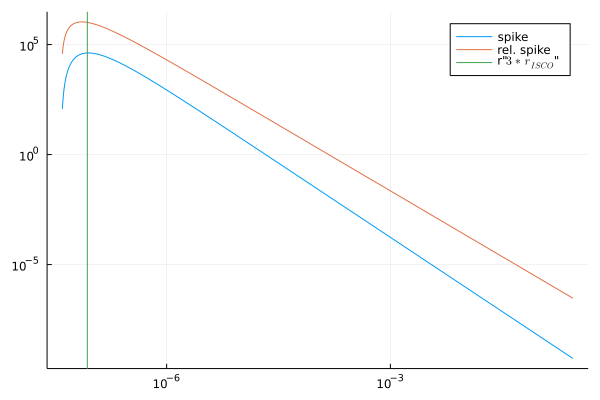

In [7]:
Rs = get_Rs(; input_dict...)
risco = 3*r_isco(;input_dict...)
rsp = get_rsp(; input_dict...)
r = np.geomspace(4e-8,2.8e-1,1000); 
r2 = np.geomspace(2e-8,2.8e-1,1000)
#rho = np.array([rho_nfw(r; input_dict...) for r in r]);
rho_s = np.array([rho_spike(r; rsp=rsp, input_dict...) for r in r])
rho_r = np.array([rho_relativistic(r; input_dict...) for r in r2])
#plot(r, rho, xaxis=:log, yaxis=:log, label="nfw")
plot(r, rho_s, xaxis=:log, yaxis=:log, label="spike")
plot!(r, rho_r, xaxis=:log, yaxis=:log, label="rel. spike")
plot!(Vector[[risco]], linetype=[:vline], widths=[2], label=r"$3*r_{ISCO}$")


## Solving the Differential Equations

In [13]:
#-------------------------Evolution Function-----------------------------------------------

function Evolve(mass, u0; kwargs...)
    """
    Evolve the system of differential equations from t_start to t_end with initial conditions u0
    """
    # Evolution params
    t_start = kwargs[:t_start]
    
    a0 = a_0(; kwargs...)
    F0 = sqrt(mass[3]/a0^3)/2/pi
    
    norbits = kwargs[:norbits]                    # Number of Orbits
    t_orbital = kwargs[:t_orbital]                  # Time-points per orbit
    nSteps = Int(norbits * t_orbital)
    t_end = norbits / F0
    
    eta = mass[4]/mass[3]
    m = mass
    
    tspan = (t_start,t_end)
    t_eval = LinRange(t_start, t_end, nSteps)
    
    # Toggle forces
    dynamicalFriction = kwargs[:dynamicalFriction]
    postNewtonian = kwargs[:postNewtonian]
    gwEmission = kwargs[:gwEmission]
    coulombLog = kwargs[:coulombLog]
    
    # Model flags
    dmModel = kwargs[:dmModel]
    dfModel = kwargs[:dfModel]
    
    #---------------------------Derivative Function---------------------------------------
    
    function orbit!(du, u, m, t)
        
        # r=u[1],  phi=u[2],  dr=u[3],  dphi=u[4]
        # m = [m1,m2,m_total,mu]
        
        v = sqrt(u[3]^2 + (u[1]^2)*(u[4])^2)
        
        if dmModel == "Newtonian"
            rho = rho_spike(u[1]; kwargs...)
        elseif dmModel == "Relativistic"
            rho = rho_relativistic(u[1]; kwargs...)
        else
            throw(DomainError(dmModel, "must be either 'Newtonian' or 'Relativistic'."))
        end
        
        if dfModel == "Newtonian"
            zeta = 0
        elseif dfModel == "Relativistic"
            zeta = 1
        else
            throw(DomainError(dfModel, "must be either 'Newtonian' or 'Relativistic'."))
        end
        
        gamma = sqrt(1 .- (zeta .*v^2))
        correction = gamma^2 .* (1 .+ (zeta .* v^2))^2
        
        P_df     = dynamicalFriction ? 4*pi*(m[2]^2 / m[4]) .* rho .* correction  .* (coulombLog/v^3) : 0.
        
        P_pn_r   = postNewtonian ? (m[3]/u[1]^2)*( (4 + 2*eta)*(m[3]/u[1]) - (3*eta +1)*(u[1]^2)*(u[4]^2) + (3 - 7*eta/2)*u[3]^2) : 0.
        
        P_pn_phi = postNewtonian ? (m[3]/u[1]^2)*(4 - 2*eta)*u[3]*u[4] : 0.
        
        P_gw_r   = gwEmission ? ( (8/5)*m[4]*(m[3]/u[1]^3)*(2*v^2 + (8/3)*(m[3]/u[1]) )) : 0.
        
        P_gw_phi = gwEmission ? ( (8/5)*m[4]*(m[3]/u[1]^3)*(v^2 + 3*(m[3]/u[1]) )) : 0.
        
        
        du[1] = u[3]  # dr
        du[2] = u[4]  # dphi
        du[3] = -(-P_gw_r + P_df)*(u[3]) + P_pn_r - (m[3]/u[1]^2) + u[1]*(u[4]^2)  # ddr
        du[4] = -(P_gw_phi + P_df)*(u[4]) + P_pn_phi - (2*u[3]*u[4]/u[1])          # ddphi
    end
    
    #---------------------Call-back functions---------------------------------------------
    
    function terminate_condition(u,t,integrator)       # condition at which the integration terminates
        u[1]< 7*r_isco(; kwargs...)
    end
    
    function terminate_affect!(integrator)
        terminate!(integrator)
    end
    
    terminate_cb =DiscreteCallback(terminate_condition,terminate_affect!)
 
    
    #-------------------------Calling the solver--------------------------------------------
    
    # call-backs do not work with lsoda() but they do work with other algorithms
    
    prob = ODEProblem(orbit!, u0, tspan, m, callback=terminate_cb)  # exclude the callback part when using lsoda()
    alg = VCABM() #lsoda() #AN5() #VCABM5() #Tsit5()  #DP5() #AutoVern7(Rodas5())  #Vern9(lazy=false) #Feagin12() #Vern7() 
    @time sol = solve(prob, alg, abstol=1e-14, reltol=1e-12, saveat=t_eval, dense=false, maxiters=Int(1e9))    # For predefined time-steps 
    #@time sol = solve(prob, alg, abstol=1e-14, reltol=1e-12, dense=true, maxiters=Int(1e9))                   # For adaptive time-steps
    return sol
end


Evolve (generic function with 1 method)

In [14]:
mass = mass_A(; input_dict...)
u0 = initial_conditions(mass; input_dict...)

solution = Evolve(mass,u0; input_dict...)

sol_trans = solution'
r = sol_trans[:,1]
phi = sol_trans[:,2]
dr = sol_trans[:,3]
dphi = sol_trans[:,4]
t = solution.t
D = input_dict[:D]

solution = nothing
sol_trans = nothing


  1.735397 seconds (2.84 M allocations: 157.527 MiB, 2.21% gc time, 97.38% compilation time)


## Calculating GW strain

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Calculating the GW strain~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#--------------------------------Strain Function------------------------------------------------
D = input_dict[:D]

function strain(mass, D, r, phi, t)
    """
    This function takes in the orbit solution arrays (r and phi) and returns the gravitational wave pattern 
    """
    
    #---------Observer parameters--------------
    mu = mass[4]
    theta_o = 0    # inclination_angle
    phi_o = 0      # pericenter_angle
    
    #---------Scaling--------------------------
    r0 = u0[1]
    r /= r0
    T = t[2]-t[1]
    
    #---------Rotating body parameters---------
    x = r.*cos.(phi)
    y = r.*sin.(phi)
    z = zeros(length(x))
    
    #--------Quadrupole Moment Tensor----------
    Q  = [ [mu*x.*x, mu*x.*y, mu*x.*z],
           [mu*y.*x, mu*y.*y, mu*y.*z],
           [mu*z.*x, mu*z.*y, mu*z.*z] ]
    
    #--------Derivative Functions---------------
    
    function Mdt(Q)     
        """
        Returns the first derivative of Quadrupole Moment Tensor with respect to time
        """
        
        dQdt = [ [np.gradient(Q[1][1], T), np.gradient(Q[1][2], T), np.gradient(Q[1][3], T)], 
                 [np.gradient(Q[2][1], T), np.gradient(Q[2][2], T), np.gradient(Q[2][3], T)],
                 [np.gradient(Q[3][1], T), np.gradient(Q[3][2], T), np.gradient(Q[3][3], T)] ]
        
        return dQdt
    end
    
    
    function Mdt2(Q) 
        """
        Returns the second derivative of Quadrupole Moment Tensor with respect to time
        """
        
        dQ2dt2 = Mdt(Mdt(Q))
        
        return dQ2dt2*(r0^2)
    end
    
    
    d2Qd2t = Mdt2(Q)
    
    
    h_plus =  (1.0/D) * (   d2Qd2t[1][1].*(cos.(phi_o).^2 - sin.(phi_o).^2 .*cos.(theta_o).^2) 
                          + d2Qd2t[2][2].*(sin.(phi_o).^2 - cos.(phi_o).^2 .*cos.(theta_o).^2) 
                          - d2Qd2t[3][3].*(sin.(theta_o).^2) 
                          - d2Qd2t[1][2].*(sin.(2*phi_o).*(1.0 .+ cos.(theta_o).^2))
                          + d2Qd2t[1][3].*(sin.(phi_o).*sin.(2*theta_o)) 
                          + d2Qd2t[2][3].*(cos.(phi_o).*sin.(2*theta_o))     ) 
    
    h_cross = (1.0/D) * (   (d2Qd2t[1][1]-d2Qd2t[2][2]).*sin.(2*phi_o).*cos.(theta_o)
                             + 2*d2Qd2t[1][2].*cos.(2*phi_o).*cos.(theta_o) 
                             - 2*d2Qd2t[1][3].*cos.(phi_o).*sin.(theta_o) 
                             + 2*d2Qd2t[2][3].*sin.(theta_o).*sin.(phi_o)    )
    
    return [h_plus, h_cross]
    
end


function strain2d(mass, D, r, phi, t)
    
    """
    This function takes in the orbit solution arrays (r and phi) and returns the gravitational wave pattern 
    """
    
    #-------------Observer parameters----------
    mu = mass[4]
    theta_o = 0    # inclination_angle
    phi_o = 0      # pericenter_angle
    
    #----------------Scaling-------------------
    r0 = u0[1]
    r /= r0
    T = t[2]-t[1]
    
    #---------Rotating body parameters---------
    x = r.*cos.(phi)
    y = r.*sin.(phi)
    
    #--------Quadrupole Moment Tensor----------
    Q  = [ [mu*x.*x, mu*x.*y],
           [mu*y.*x, mu*y.*y] ]
    
    
    #--------Derivative Functions---------------

    function Mdt(Q)     
        """
        Returns the first derivative of Quadrupole Moment Tensor with respect to time
        """
        
        dQdt = [ [np.gradient(Q[1][1], T), np.gradient(Q[1][2], T)], 
                 [np.gradient(Q[2][1], T), np.gradient(Q[2][2], T)], ]
        
        return dQdt
    end
    
    
    function Mdt2(Q) 
        """
        Returns the second derivative of Quadrupole Moment Tensor with respect to time
        """
        
        dQ2dt2 = Mdt(Mdt(Q))
        
        return dQ2dt2*(r0^2)
    end
    
    
    d2Qd2t = Mdt2(Q)
    
    
    h_plus =  (1.0/D) * (   d2Qd2t[1][1].*(cos.(phi_o).^2) 
                          + d2Qd2t[2][2].*(-cos.(phi_o).^2 .*cos.(theta_o).^2)  )
    
    return h_plus
    
end


#--------------------------------FFT Function------------------------------------------------

function strainFFT(t, strain, f_bin)
    N = length(t)
    T = t[2] - t[1]
    
    h_plus_fft = SciPy.fft.fft(strain[1,:])/(2*pi*N)
    h_cross_fft = SciPy.fft.fft(strain[2,:])/(2*pi*N)
    xf = SciPy.fft.fftfreq(N, T)  #[1:Int(N ÷ 2)] 
    
    h_plus_fft = h_plus_fft[(xf .> f_bin[1]) .&& (xf .< f_bin[2])]
    h_cross_fft = h_cross_fft[(xf .> f_bin[1]) .&& (xf .< f_bin[2])]
    xf = xf[(xf .> f_bin[1]) .&& (xf .< f_bin[2])]

    return [xf, h_plus_fft, h_cross_fft]
end


function strainFFT2d(t, strain, f_bin)
    N = length(t)
    T = t[2] - t[1]
    
    h_plus_fft = SciPy.fft.fft(strain[:])/(2*pi*N)
    xf = SciPy.fft.fftfreq(N, T) #[1:Int(N ÷ 2)]
    
    h_plus_fft = h_plus_fft[(xf .> f_bin[1]) .&& (xf .< f_bin[2])]
    xf = xf[(xf .> f_bin[1]) .&& (xf .< f_bin[2])]
    
    return [xf , h_plus_fft]
end


strainFFT2d (generic function with 1 method)

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Calculating the Strain~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
hz_to_invpc = 1.029e8
gw_strain  = strain2d(mass, D, r, phi, t);
strain_FFT  = strainFFT2d(t, gw_strain, [1e-4*hz_to_invpc, 1e-1*hz_to_invpc]);


## Producing Datasets

In [8]:
# semi-major axis data
mass = mass_A(; input_dict...)
m_total = mass[3]

v   = sqrt.(dr.^2 + (r.^2 .* dphi.^2))
sma = m_total*(1 ./abs.(v.^2 - 2*m_total ./r)) 

sma_data = hcat(t[:],sma[:])     # Stacking the matrices together

#-----------------------------------------------------------------------------
CSV.write("semi_major_axis_spike_Orb1k_dp100_alpha_2point50.csv", Tables.table(sma_data), writeheader=false)

#--------------------------To release memory----------------------------------
v = nothing
sma = nothing
sma_data = nothing;

In [9]:
# GW Strain Data

gw_data = hcat(t[:],gw_strain[:])

#-----------------------------------------------------------------------------
CSV.write("GW_strain_spike_Orb1k_dp100_alpha_2point50.csv", Tables.table(gw_data), writeheader=false)

#--------------------------To release memory----------------------------------
gw_data = nothing

In [10]:
# Charatteristic Strain Data

f_start   = 1
f_end     = length(strain_FFT[1])
frequency = abs.(strain_FFT[1][f_start:f_end])/hz_to_invpc
h_char    = 2*abs.(strain_FFT[1][f_start:f_end]) .* abs.(strain_FFT[2][f_start:f_end])

char_strain_data = hcat(frequency[:], h_char[:])

#-----------------------------------------------------------------------------
CSV.write("char_strain_spike_Orb1k_dp100_alpha_2point50.csv", Tables.table(char_strain_data), writeheader=false)

#--------------------------To release memory----------------------------------

frequency = nothing
h_char = nothing
char_strain_data = nothing